## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir + '/src')

In [2]:
from policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from dataset.demos import Demos, PartialFrameViewDemos
import policy.models.tpgmm
from utils.misc import load_scene_data, DataNamingConfig
from utils.logging import setup_logger  # noqa: F401
from utils.franka import reconstruct_actions
from viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-06-20 12:00:13.320 | INFO     |  Running on cuda:0


In [3]:
task = 'Cabinet'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-06-20 12:00:14.866 | INFO     |  Loading dataset(s): 
2024-06-20 12:00:14.872 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Cabinet/demos/metadata.json
2024-06-20 12:00:14.874 | INFO     |    Extracted gt object labels []
2024-06-20 12:00:14.874 | INFO     |    Extracted tsdf object labels []
2024-06-20 12:00:14.875 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'dbg',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_down=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    # kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-06-20 12:00:16.975 | INFO     |  Subsampling to length 296 using strategy mean-length.


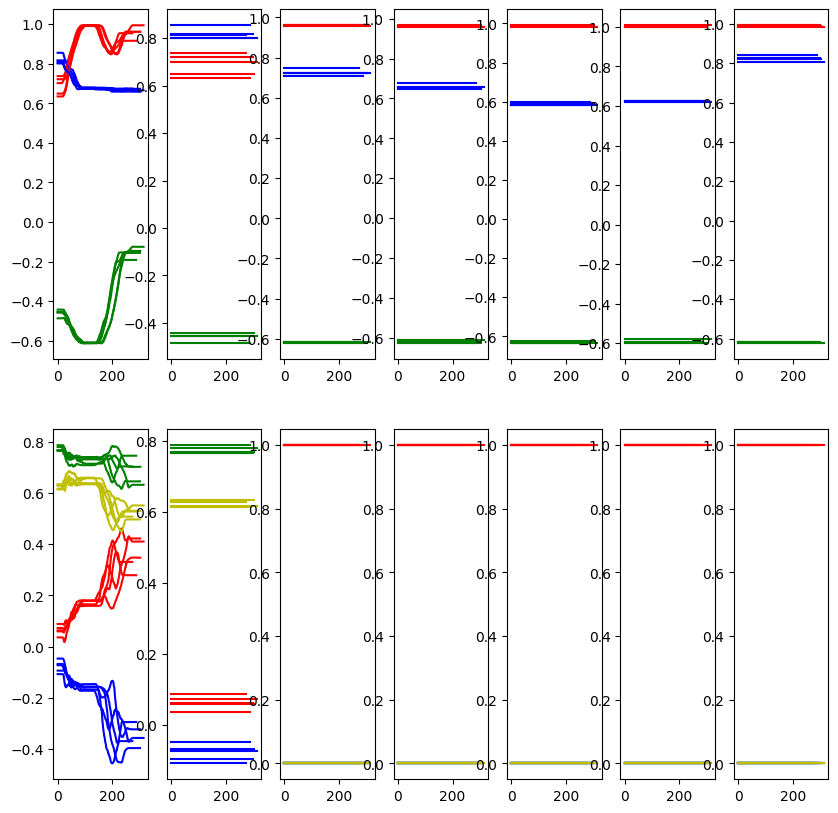

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.0,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=4,

    velocity_threshold=0.002,
    max_idx_distance=1,

    no_segmentation=True,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-06-20 12:00:18.014 | INFO     |  Fitting AutoTPGMM
2024-06-20 12:00:18.014 | INFO     |  Performing fitting actions: [INIT]
2024-06-20 12:00:18.014 | INFO     |  Segmenting trajectories
2024-06-20 12:00:18.014 | INFO     |  ... created 1 segments
2024-06-20 12:00:18.015 | INFO     |    Fitting candidate frame 1/6
2024-06-20 12:00:18.015 | INFO     |    Creating partial frame view of demos.
2024-06-20 12:00:18.032 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-06-20 12:00:18.033 | INFO     |    Changing number of components to 20
2024-06-20 12:00:18.033 | INFO     |    Model init ...


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:19.499 | INFO     |    Fitting candidate frame 2/6
2024-06-20 12:00:19.499 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:20.905 | INFO     |    Fitting candidate frame 3/6
2024-06-20 12:00:20.906 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:22.296 | INFO     |    Fitting candidate frame 4/6
2024-06-20 12:00:22.296 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:23.738 | INFO     |    Fitting candidate frame 5/6
2024-06-20 12:00:23.739 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:25.269 | INFO     |    Fitting candidate frame 6/6
2024-06-20 12:00:25.269 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:26.777 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-06-20 12:00:26.777 | INFO     |  kp 0       score (rel):     -0 (0.184)
2024-06-20 12:00:26.777 | INFO     |  kp 1       score (rel):     -0 (0.294)
2024-06-20 12:00:26.778 | INFO     |  kp 2       score (rel):     -0 (0.295)
2024-06-20 12:00:26.778 | INFO     |  kp 3       score (rel):     -0 (0.269)
2024-06-20 12:00:26.778 | INFO     |  kp 4       score (rel):     -0 (0.320)
2024-06-20 12:00:26.778 | INFO     |  Creating partial frame view of demos.
2024-06-20 12:00:26.855 | INFO     |  Segmented trajs into 1 segments
2024-06-20 12:00:26.857 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.998044 -0.183464 -0.293075 -0.293971 -0.268303 -0.319052
2024-06-20 12:00:26.858 | INFO     |  Frame score (rel):
           ee_init      kp 0     kp 1      kp 2      kp 3      kp 4
Segment 0      1.0  0.183824  0.29365  0.294547  0.268829  0.319678


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 12:00:26.864 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

((array([[5.70e+60, 7.56e+60, 9.63e+60, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.02e+50, 8.66e+50, 6.66e+51, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.47e+20, 3.29e+22, 3.75e+24, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.20e+46, 9.28e+45, 1.94e+45],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 3.05e+54, 1.28e+54, 5.06e+53],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.47e+59, 4.84e+59, 3.44e+59]]),),
 (-136.5566021774246,))

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-06-20 12:00:32.959 | INFO     |  Fitting AutoTPGMM
2024-06-20 12:00:32.961 | INFO     |  Segmenting trajectories
2024-06-20 12:00:32.961 | INFO     |  ... created 1 segments
2024-06-20 12:00:32.961 | INFO     |    Fitting candidate frame 1/6
2024-06-20 12:00:32.961 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:34.554 | INFO     |    Fitting candidate frame 2/6
2024-06-20 12:00:34.555 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:36.130 | INFO     |    Fitting candidate frame 3/6
2024-06-20 12:00:36.131 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:37.945 | INFO     |    Fitting candidate frame 4/6
2024-06-20 12:00:37.946 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:39.418 | INFO     |    Fitting candidate frame 5/6
2024-06-20 12:00:39.419 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:41.071 | INFO     |    Fitting candidate frame 6/6
2024-06-20 12:00:41.071 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

2024-06-20 12:00:42.612 | INFO     |  Creating partial frame view of demos.
2024-06-20 12:00:42.613 | INFO     |  Segmented trajs into 1 segments
2024-06-20 12:00:42.615 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1      kp 2      kp 3      kp 4
Segment 0 -0.998044 -0.183464 -0.293075 -0.293971 -0.268303 -0.319052
2024-06-20 12:00:42.616 | INFO     |  Frame score (rel):
           ee_init      kp 0     kp 1      kp 2      kp 3      kp 4
Segment 0      1.0  0.183824  0.29365  0.294547  0.268829  0.319678


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/20 [00:00<?, ?it/s]

((array([[5.70e+60, 7.56e+60, 9.63e+60, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.02e+50, 8.66e+50, 6.66e+51, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [2.47e+20, 3.29e+22, 3.75e+24, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.20e+46, 9.28e+45, 1.94e+45],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 3.05e+54, 1.28e+54, 5.06e+53],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.47e+59, 4.84e+59, 3.44e+59]]),),
 (-136.5566021774246,))

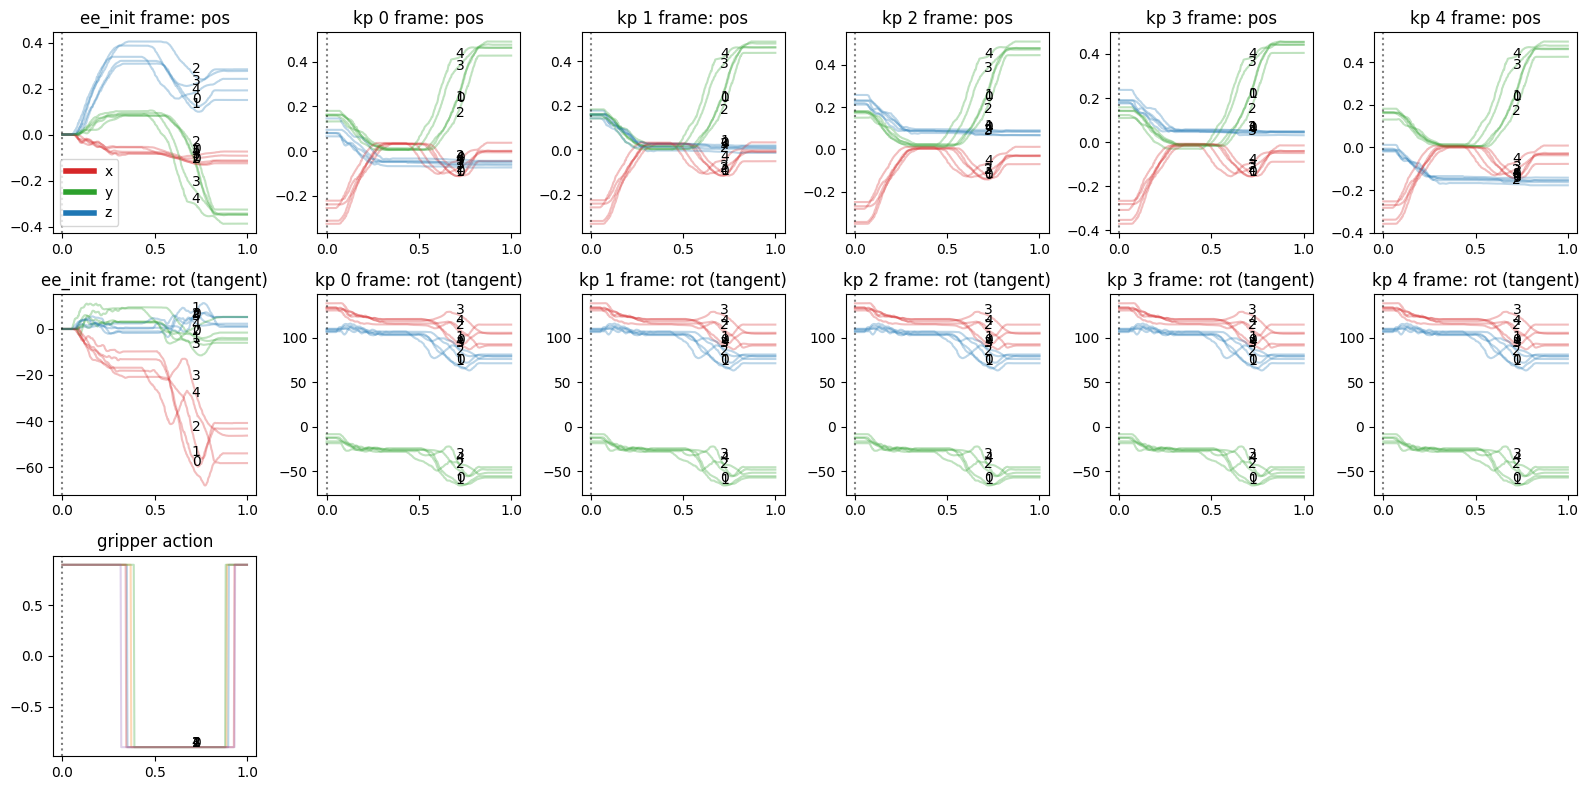

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-06-20 12:00:49.677 | INFO     |  Fitting AutoTPGMM
2024-06-20 12:00:49.677 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 12:00:49.681 | INFO     |  HMM EM ...
2024-06-20 12:00:49.700 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 12:00:51.170 | INFO     |  HMM init priors not defined, initializing to uniform
2024-06-20 12:01:17.355 | WARNING  |  HMM EM did not converge


((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.79e-11, 1.15e-10, 6.92e-10, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [4.34e-41, 4.35e-39, 3.90e-37, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 6.49e-14, 1.92e-14, 5.65e-15],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.71e-06, 2.64e-06, 1.47e-06],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),),
 (40420.75424451768,))

2024-06-20 12:01:17.445 | INFO     |  Did not specify time_based, deciding automatically.


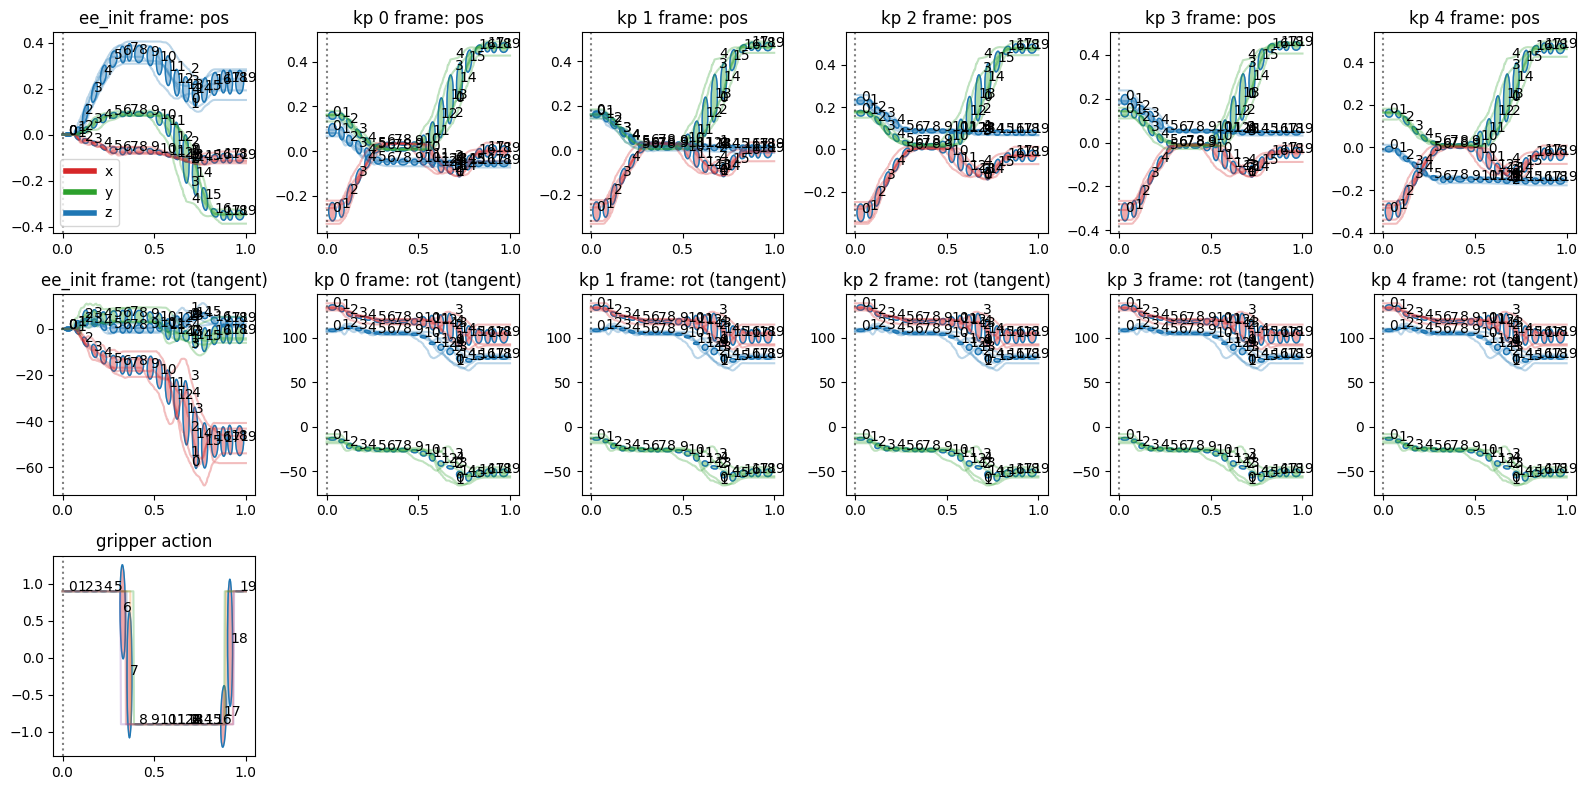

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-tx-tpgmm.pt')

2024-06-20 12:01:22.529 | INFO     |  Saving model:


2024-06-20 12:01:22.599 | INFO     |  Did not specify time_based, deciding automatically.


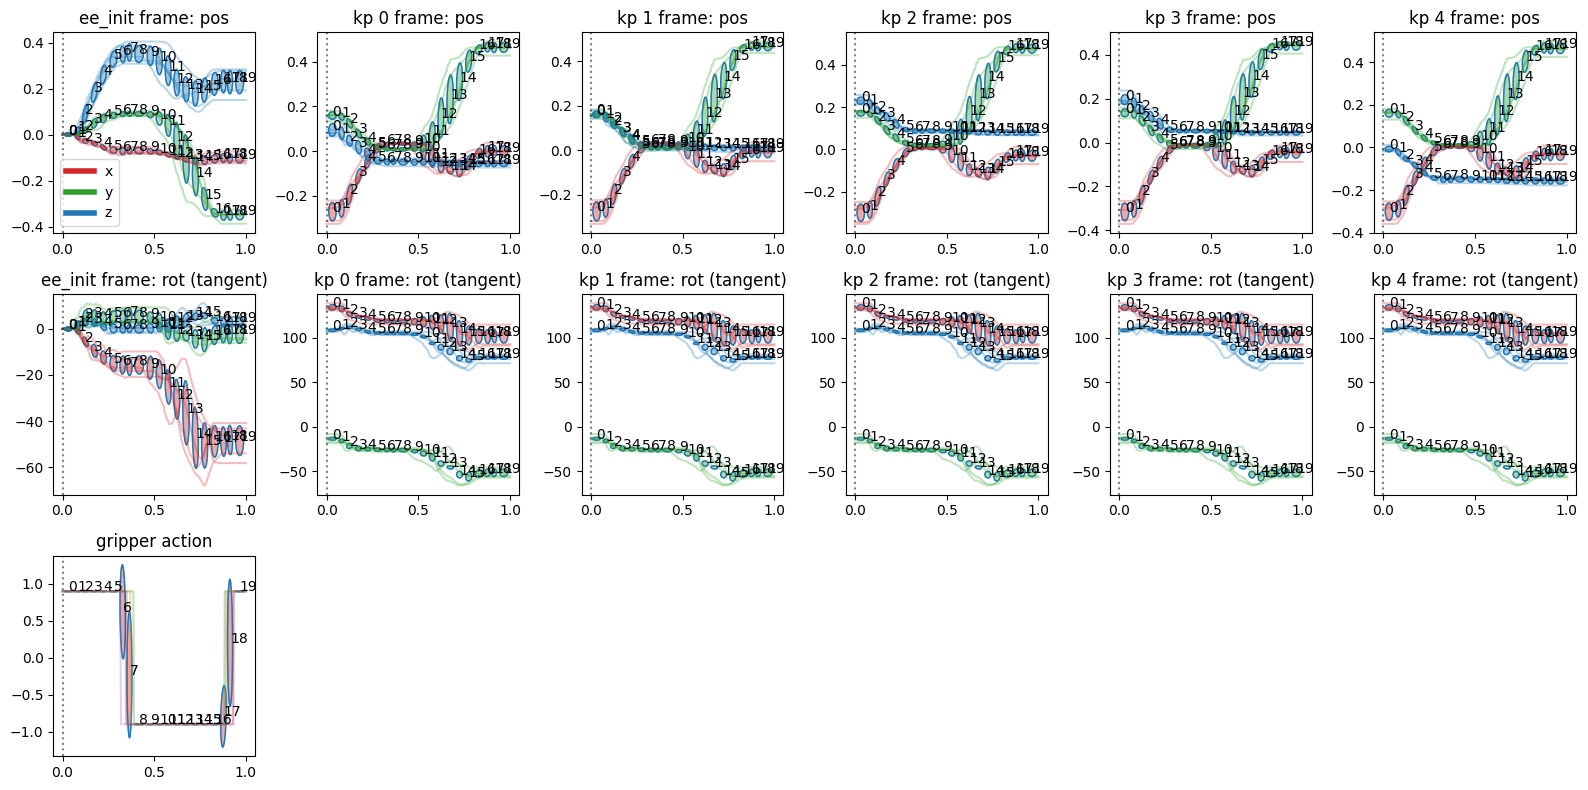

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


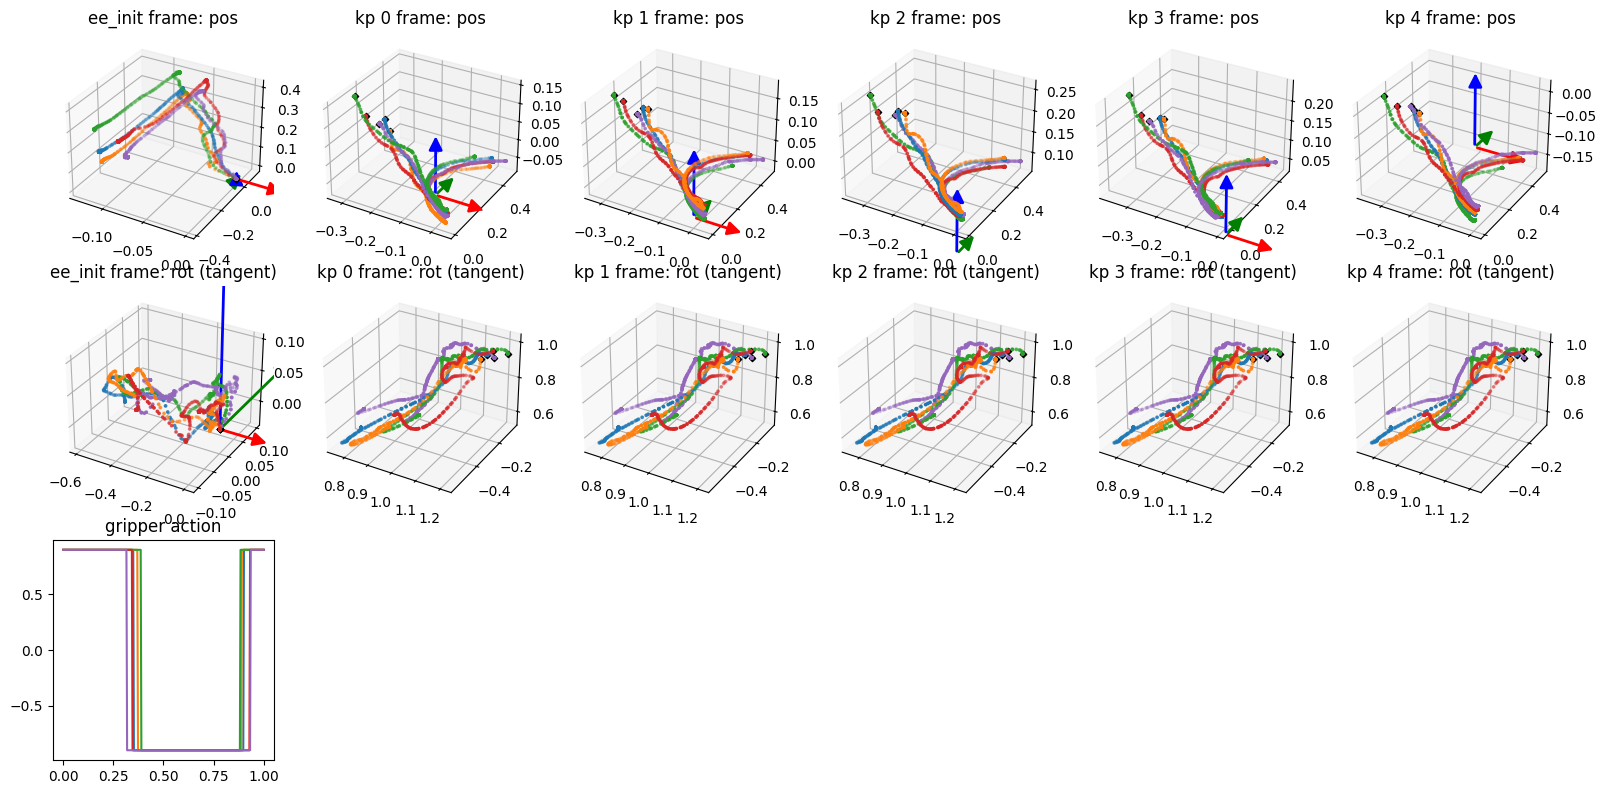

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-06-20 12:01:29.346 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-06-20 12:01:29.347 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 6, got 4)

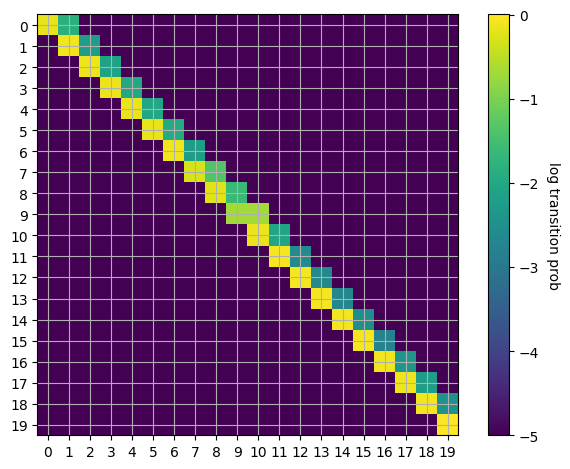

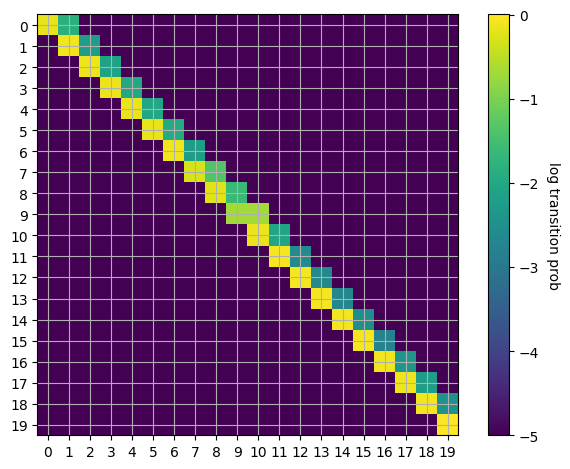

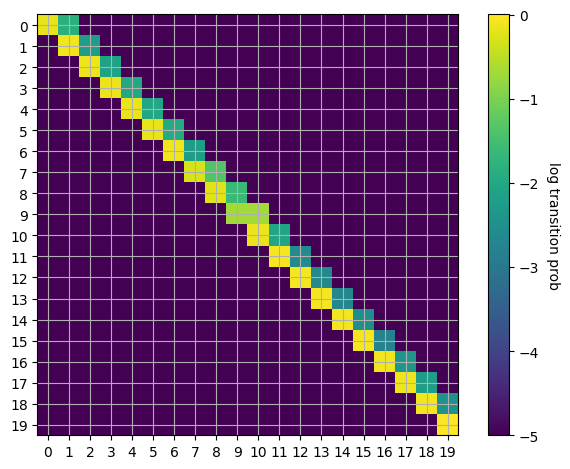

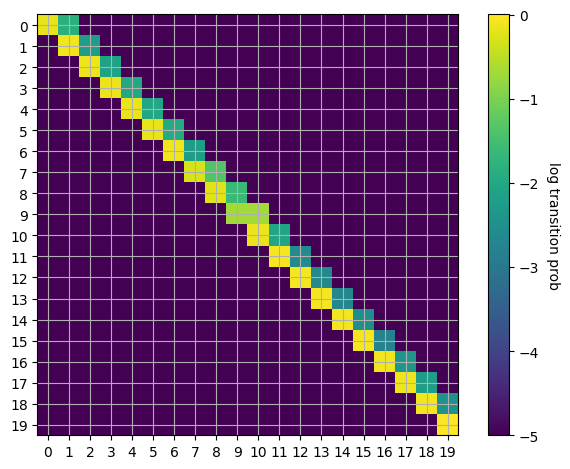

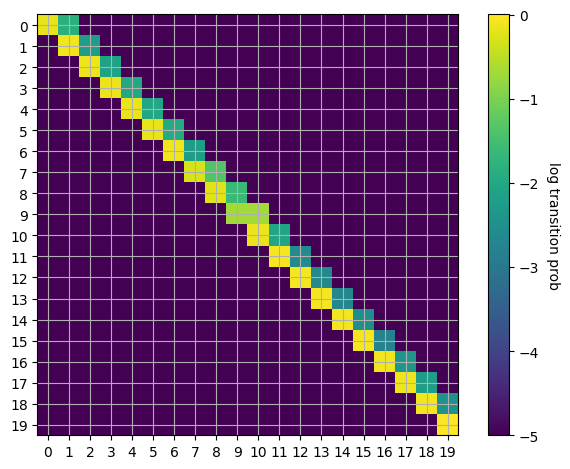

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-06-18 12:51:55.980 | INFO     |  Taking frame origins from demos.


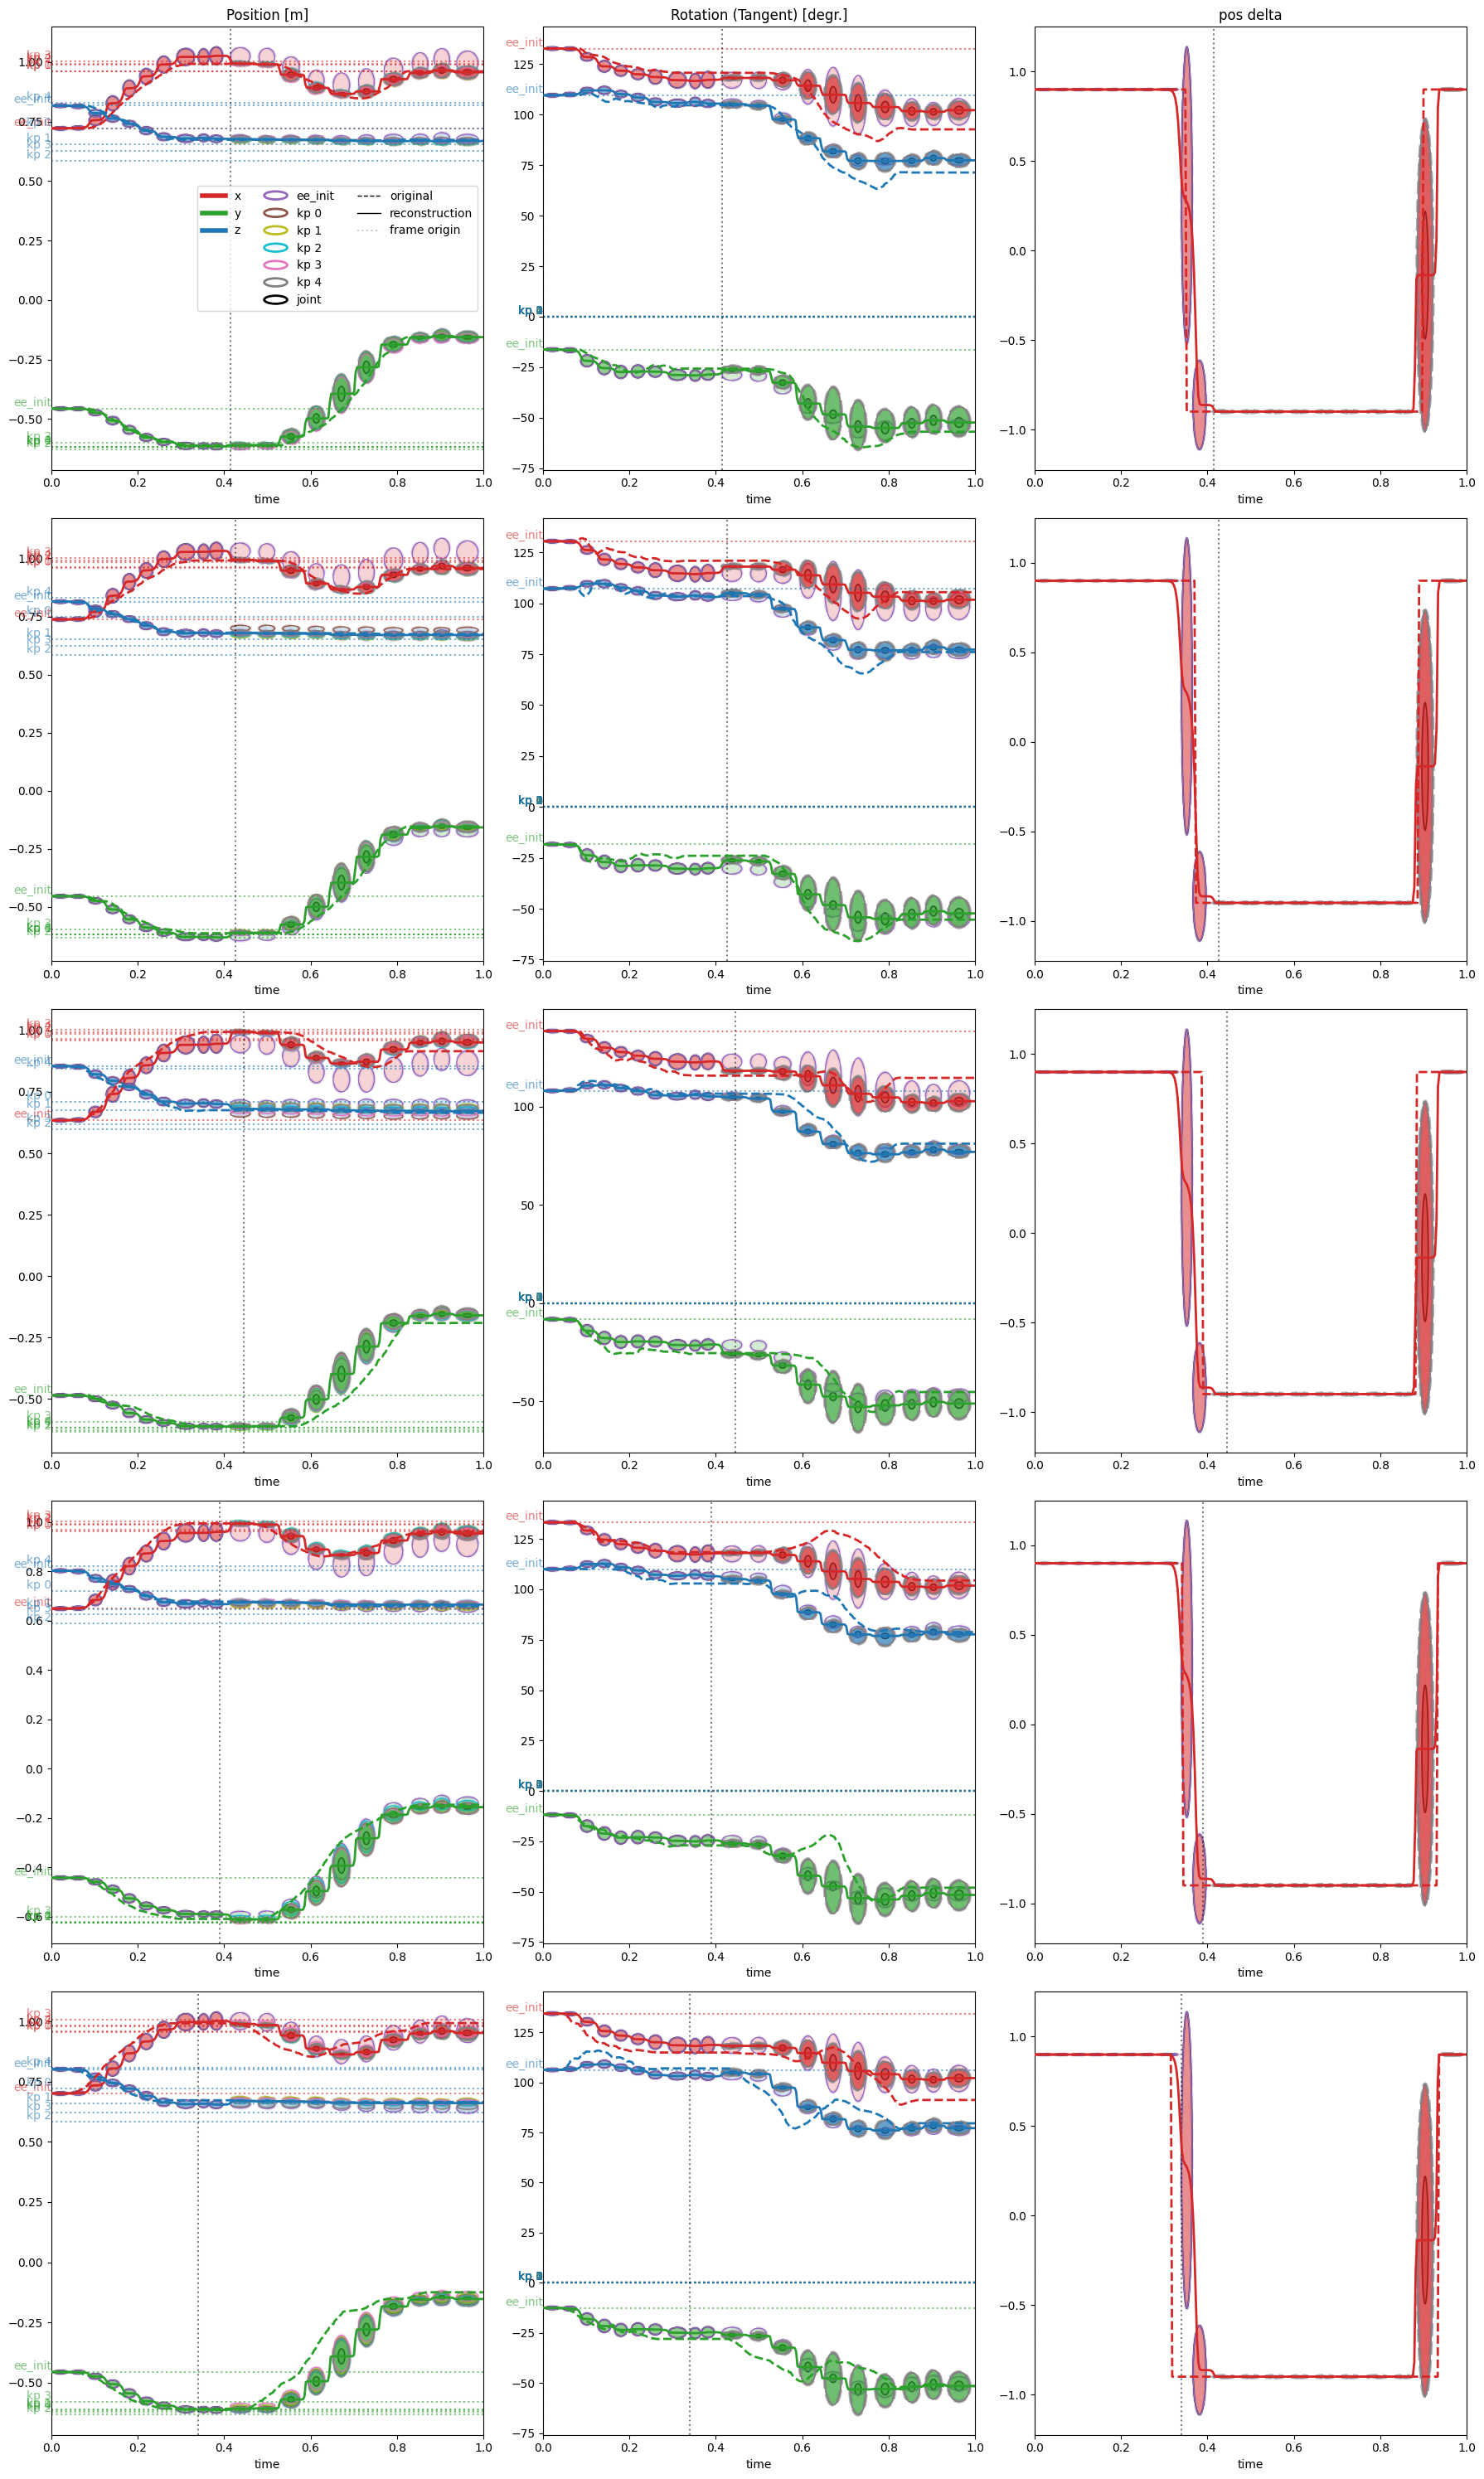

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


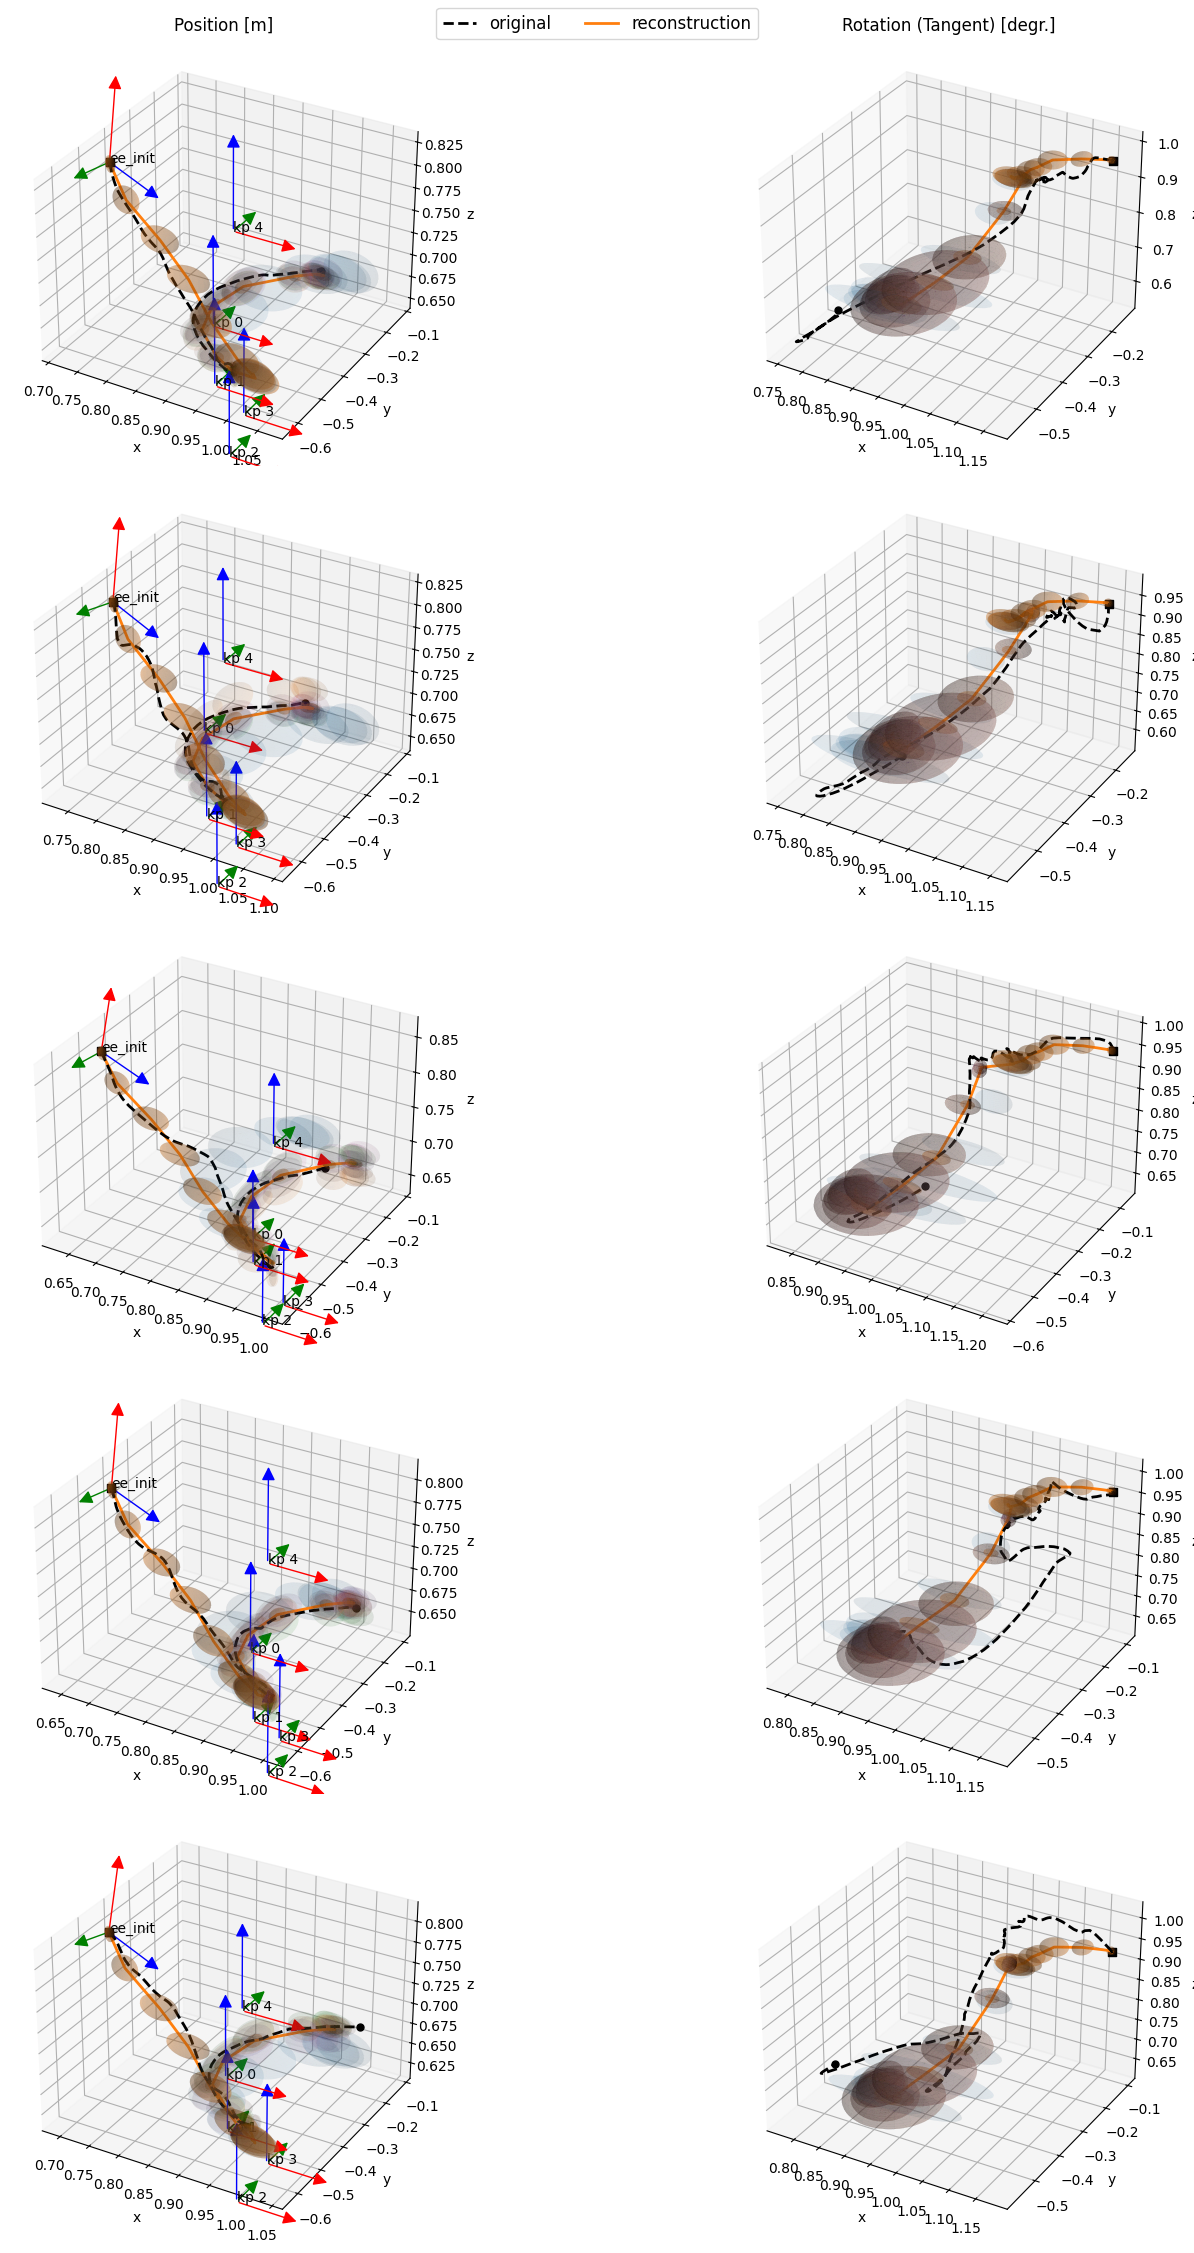

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)